In [14]:
import os
import time

import numpy as np
import ipyvolume as ipv
from pathlib import Path

from tyssue import Sheet, config
from tyssue.io import hdf5
from tyssue.draw.ipv_draw import view_ipv
from tyssue.draw.ipv_draw import sheet_view as ipv_sheet_view
from tyssue.draw.ipv_draw import view_ipv
from tyssue.core.sheet import get_opposite
from tyssue.draw.plt_draw import quick_edge_draw,sheet_view, plot_scaled_energies
from invagination.ellipsoid import EllipsoidGeometry as geom
from invagination.toolbox import (open_sheet,
                                 define_depth)

import matplotlib.pyplot as plt
%matplotlib inline

SIM_DIR = Path('/home/admin-suz/Documents/Simulations/Surface_tension/2018-11-28')
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/test/')


old = None

In [15]:
import datetime
today = datetime.date.today()
dirname = SIM_DIR/f'{today.isoformat()}'


dirname = SIM_DIR/'1.08_contractility_5_critical_area_30_radialtension_0/'

## 3D view

In [24]:
from tyssue.draw import sheet_view

import ipyvolume.pylab as p3
hfs = [f  for f in os.listdir(dirname)
       if f.endswith('hf5')]
hfs.sort(key=lambda x: os.path.getctime(os.path.join(dirname, x)))

current = 'invagination_0005.hf5'
ipv.clear()
ipv.style.use('dark')
dsets = hdf5.load_datasets(os.path.join(dirname, current),
                               data_names=['vert', 'edge', 'face'])
specs = config.geometry.cylindrical_sheet()
sheet = Sheet('ellipse', dsets, specs)
#sheet = sheet.extract_bounding_box(z_boundary=[-200,50])
def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color': sheet.vert_df.y
        },
        'face': {
            'visible': True,
            'color': sheet.face_df.area,
            'color_range': (sheet.face_df.area.min(), 20),
            'colormap': 'viridis'
        }
    }
    return specs

ipv.clear()
ipv_fig, meshes = sheet_view(sheet, coords=list('zxy'),
                             mode='3D', **draw_specs(sheet))
ipv_fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.274128, 0.199721, 0.498911],
       [0.535621, 0.835785, 0.281908],
       [0.283072, 0.130895, 0.449241],
       ...,
       [0.647257, 0.8584  , 0.209861],
       [0.137339, 0.662252, 0.515571],
       [0.709898, 0.868751, 0.169257]]), lines=array([[11748, 11825],
       [11281, 11598],
       [ 7579,  7580],
       ...,
       [ 4910,  4908],
       [ 8940,  8946],
       [    0,  1365]], dtype=uint32), texture=None, x=array([ 87.8164115 , -77.01526748,  85.70607661, ...,  68.58384389,
       -99.70423721,  87.70062518]), y=array([-33.33779566, -48.44369328,  -2.84000341, ..., -43.50764079,
       -60.04319716, -16.27239726]), z=array([-60.04646145,  54.76347507, -69.47004758, ...,  62.03729573,
        17.92778846,  66.34170375])), Mesh(color=array([[0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       ...,
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936]]), texture=None, triangles=array([[ 5786,  5938, 41554],
       [ 5801,  5939, 41555],
       [ 4718,  5940, 41556],
       ...,
       [ 3647, 41551, 77167],
       [ 1467, 41552, 77168],
       [    0, 41553, 77169]], dtype=uint32), x=array([ 84.76045006,  89.83539809,  89.16896525, ..., -29.45555617,
       -74.54523784,  87.03124663]), y=array([-34.27572858, -34.82747518, -30.54686887, ...,  83.28188856,
       -37.69494472, -35.83645267]), z=array([-60.97126161, -57.99821396, -60.69358498, ...,   6.57819827,
       -63.59650737, -58.98980174]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-164.90213258360527, 164.94857894259516], ylim=[-164.90213258360527, 164.94857894259516], zlim=[-164.90213258360527, 164.94857894259516])

(<matplotlib.figure.Figure at 0x7f688105c128>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68811a7dd8>)

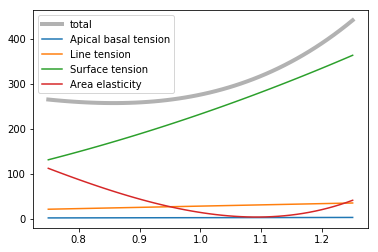

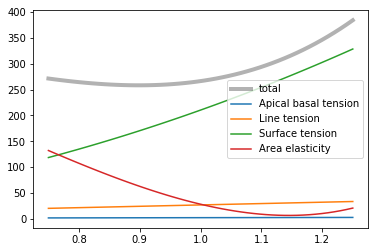

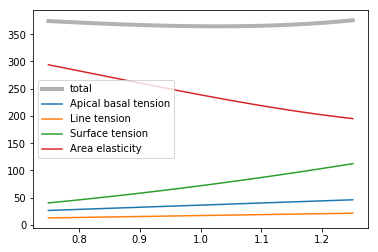

In [13]:
from tyssue.dynamics.factory import model_factory
from invagination.ellipsoid import VitellineElasticity, RadialTension
from tyssue.dynamics import effectors, units

specs = config.geometry.cylindrical_sheet()
EllipsoidBModel = model_factory(
    [
    RadialTension,
    #VitellineElasticity,
    effectors.LineTension,
    effectors.SurfaceTension,
    effectors.FaceAreaElasticity,
    #effectors.CellVolumeElasticity,
    #effectors.FaceContractility,
    ], effectors.FaceAreaElasticity)

model = EllipsoidBModel

current = 'invagination_0001.hf5'
dsets = hdf5.load_datasets(os.path.join(dirname, current),
                               data_names=['vert', 'edge', 'face'])
sheet = Sheet('ellipse', dsets, specs)
sheet = sheet.extract('is_mesoderm')
sheet.settings['abc']=[84.99999999999999, 84.99999999999999, 149.99999999999997]
sheet.settings['vitelline_space']= 0.2
plot_scaled_energies(sheet, geom, model, np.linspace(0.75,1.25))


current = 'invagination_0005.hf5'
dsets = hdf5.load_datasets(os.path.join(dirname, current),
                               data_names=['vert', 'edge', 'face'])
sheet = Sheet('ellipse', dsets, specs)
sheet = sheet.extract('is_mesoderm')
sheet.settings['abc']=[84.99999999999999, 84.99999999999999, 149.99999999999997]
sheet.settings['vitelline_space']= 0.2
plot_scaled_energies(sheet, geom, model, np.linspace(0.75,1.25))

current = 'invagination_0020.hf5'
dsets = hdf5.load_datasets(os.path.join(dirname, current),
                               data_names=['vert', 'edge', 'face'])
sheet = Sheet('ellipse', dsets, specs)
sheet = sheet.extract('is_mesoderm')
sheet.settings['abc']=[84.99999999999999, 84.99999999999999, 149.99999999999997]
sheet.settings['vitelline_space']= 0.2
plot_scaled_energies(sheet, geom, model, np.linspace(0.75,1.25))

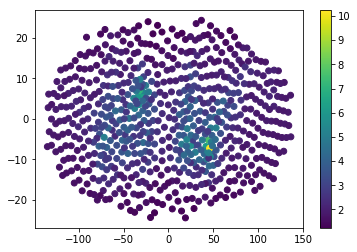

In [258]:
plt.scatter(sheet.face_df[(sheet.face_df['is_mesoderm']) ]['z'],
         sheet.face_df[(sheet.face_df['is_mesoderm']) ]['x'],
        c=sheet.face_df[(sheet.face_df['is_mesoderm'])]['contractility']
)
plt.colorbar()


In [282]:
sheet.face_df.area.mean()

23.33879625620021

In [122]:
ab_tension, _, contractility, *_ = model.compute_energy(sheet, full_output=True)

In [129]:
(ab_tension.sum() / contractility.loc[face_mesoderm].sum())


0.8850516503288558

In [156]:
import ipyvolume.pylab as p3
hfs = [f  for f in os.listdir(dirname)
       if f.endswith('hf5')]
hfs.sort(key=lambda x: os.path.getctime(os.path.join(dirname, x)))

current = 'invagination_0004.hf5'
ipv.clear()
ipv.style.use('dark')



dsets = hdf5.load_datasets(os.path.join(dirname, current),
                               data_names=['vert', 'edge', 'face', 'cell'])

specs = config.geometry.cylindrical_sheet()
sheet = Sheet('ellipse', dsets, specs)

datasets={}
datasets['face'] = sheet.face_df[sheet.face_df['contractility']>=0.5].copy()

datasets['edge'] = sheet.edge_df[sheet.edge_df['face'].isin(
                    datasets['face'].index)].copy()
datasets['vert'] = sheet.vert_df.loc[sheet.edge_df['srce'].unique()].copy()

sheet = Sheet('subsheet', datasets, sheet.specs)
sheet.reset_index()
sheet.reset_topo()

sheet = sheet.extract_bounding_box(x_boundary=(-50,200), y_boundary=(-50,200))


"""mean_area = sheet.face_df[~sheet.face_df['is_mesoderm']].area.mean()
rel_area = (sheet.face_df['area'] / mean_area)"""

mean_area = sheet.face_df.height.mean()
rel_area = 1/(sheet.face_df['height'] / mean_area)

mean_edge = sheet.edge_df.cell.mean()
rel_edge = (sheet.edge_df['cell'] / mean_edge)

face_spec = {'color': rel_area, 
             'color_range': (0.8, 1.8),
             'visible': True,
             'epsilon': 0.1,
            'colormap':'Greens'}

edge_spec = {'color':rel_edge,
            'visible':True,
            'espilon':0.1,
            'colormap':'magma'
            }

fig, meshes = ipv_sheet_view(sheet, mode='3D', face=face_spec, edge=edge_spec)


fig.anglex = -1.3
fig.angley = 0.7
fig.anglez = 0.7
ipv.show()


/home/admin-suz/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: RuntimeWarning: invalid value encountered in reduce
  return getattr(obj, method)(*args, **kwds)
/home/admin-suz/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/admin-suz/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


VBox(children=(Figure(anglex=-1.3, angley=0.7, anglez=0.7, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.001462, 0.000466, 0.013866],
       [0.001462, 0.000466, 0.013866],
       [0.001462, 0.000466, 0.013866],
       ...,
       [0.001462, 0.000466, 0.013866],
       [0.001462, 0.000466, 0.013866],
       [0.001462, 0.000466, 0.013866]]), lines=array([[    0,  2353],
       [    1,    64],
       [    2,   212],
       ...,
       [11873,  2159],
       [11872, 11873],
       [11859, 11872]], dtype=uint32), texture=None, x=array([ 51.66265011, -38.69842781, -12.82562862, ...,  84.0269613 ,
        83.31232595,  82.80070334]), y=array([16.06460012, 72.37501475, 82.75344333, ...,  4.82577847,
        6.37395673,  8.73395329]), z=array([114.88837981, -40.28102536,  27.67113512, ..., -23.33273845,
       -29.33477224, -31.83888966])), Mesh(color=array([[0.83852364, 0.93697809, 0.8149481 ],
       [0.83852364, 0.93697809, 0.8149481 ],
       [0.82745098, 0.93254902, 0.80313725],
       ...,
       [0.83852364, 0.93697809, 0.8149481 ],
       [0.83852364, 0.93697809, 0.8149481 ],
       [0.83852364, 0.93697809, 0.8149481 ]]), texture=None, triangles=array([[ 3335,  3429, 23995],
       [ 3347,  3430, 23996],
       [ 2639,  3431, 23997],
       ...,
       [ 1975, 23992, 44558],
       [ 1975, 23993, 44559],
       [ 1975, 23994, 44560]], dtype=uint32), x=array([-47.92961972, -46.11437239, -47.48865645, ...,  82.45274792,
        82.81357683,  83.27403718]), y=array([ 53.56573234,  56.42000413, -48.1595527 , ...,  12.04750857,
         8.85089402,   6.72689712]), z=array([-80.42159742, -77.5779057 ,  89.74433993, ..., -31.19937845,
       -31.58079726, -29.32709159]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-164.90213258360527, 164.94857894259516], ylim=[-164.90213258360527, 164.94857894259516], zlim=[-164.90213258360527, 164.94857894259516]),))

## Ventral view of cells at the beginning

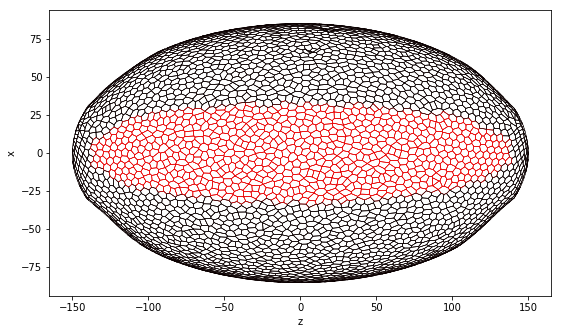

In [4]:
draw_specs = config.draw.sheet_spec()
sheet = open_sheet(dirname, 1)
sheet = sheet.extract_bounding_box(y_boundary=[0, 100])
fig, ax = plt.subplots()
edge_mask = 'is_mesoderm'
edge_mask_color_map='hot'
coords=['z', 'x']

list_edge_in_mesoderm = sheet.edge_df['face'].isin(
    sheet.face_df[sheet.face_df[edge_mask]].index)

cmap_edge = np.ones(sheet.edge_df.shape[0]) * list_edge_in_mesoderm/4
sheet.edge_df['col'] = cmap_edge / (max(cmap_edge))/4

cmap_edge = plt.cm.get_cmap(edge_mask_color_map, 4)
edge_color_cmap = cmap_edge(sheet.edge_df.col)
draw_specs['edge']['color'] = edge_color_cmap

draw_specs['edge']['visible'] = True
draw_specs['edge']['alpha'] = 0.7
draw_specs['vert']['visible'] = False
draw_specs['face']['visible'] = False
draw_specs['face']['alpha'] = 0.6

fig, ax = sheet_view(sheet, coords=coords, ax=ax, **draw_specs)
ax.set_xlabel(coords[0])
ax.set_ylabel(coords[1])

fig.set_size_inches(9.25, 5.25, forward=True)


ax.grid(False)
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
#ax.axis('off')

/home/admin-suz/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


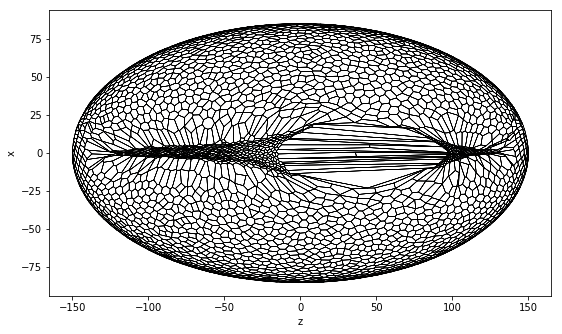

In [15]:
draw_specs = config.draw.sheet_spec()
sheet = open_sheet(dirname, 50)
sheet = sheet.extract_bounding_box(y_boundary=[0, 100])
fig, ax = plt.subplots()
edge_mask_color_map='gist_gray'
coords=['z', 'x']

list_cutting_edge = sheet.edge_df['face'].isin(
    sheet.face_df[sheet.face_df['contractility']<0.01].index)

cmap_edge = np.ones(sheet.edge_df.shape[0]) * list_cutting_edge
sheet.edge_df['col'] = cmap_edge / (max(cmap_edge))

cmap_edge = plt.cm.get_cmap(edge_mask_color_map, 2)
edge_color_cmap = cmap_edge(sheet.edge_df.col)
draw_specs['edge']['color'] = edge_color_cmap

draw_specs['edge']['visible'] = True
draw_specs['edge']['alpha'] = 1
draw_specs['vert']['visible'] = False
draw_specs['face']['visible'] = False
draw_specs['face']['alpha'] = 0.6

fig, ax = sheet_view(sheet, coords=coords, ax=ax, **draw_specs)
ax.set_xlabel(coords[0])
ax.set_ylabel(coords[1])

fig.set_size_inches(9.25, 5.25, forward=True)


ax.grid(False)
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
#ax.axis('off')
#fig.savefig('../post_ablation.png', dpi = 150)

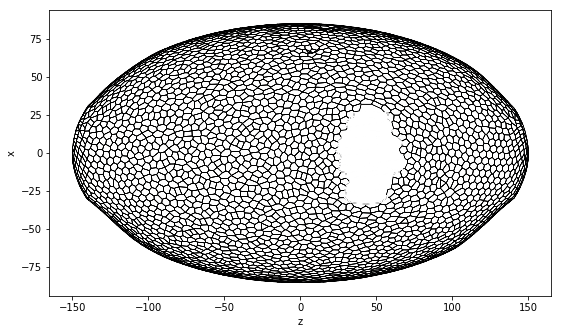

In [31]:
SIM_DIR = Path('/home/admin-suz/Documents/short_simulation/file_to_copy/2018-09-08_TEST3')
dirname = SIM_DIR/'1.08_contractility_5_critical_area_30_radialtension_0/'

draw_specs = config.draw.sheet_spec()
sheet = open_sheet(dirname, 1)
sheet = sheet.extract_bounding_box(y_boundary=[0, 150])
fig, ax = plt.subplots()
edge_mask_color_map='gist_gray'
coords=['z', 'x']

list_cutting_edge = sheet.edge_df['face'].isin(
    sheet.face_df[sheet.face_df['contractility']<=0.5].index)

cmap_edge = np.ones(sheet.edge_df.shape[0]) * list_cutting_edge
sheet.edge_df['col'] = cmap_edge / (max(cmap_edge))

cmap_edge = plt.cm.get_cmap(edge_mask_color_map, 2)
edge_color_cmap = cmap_edge(sheet.edge_df.col)
draw_specs['edge']['color'] = edge_color_cmap

draw_specs['edge']['visible'] = True
draw_specs['edge']['alpha'] = 1
draw_specs['vert']['visible'] = False
draw_specs['face']['visible'] = False
draw_specs['face']['alpha'] = 0.6

fig, ax = sheet_view(sheet, coords=coords, ax=ax, **draw_specs)
ax.set_xlabel(coords[0])
ax.set_ylabel(coords[1])

fig.set_size_inches(9.25, 5.25, forward=True)


ax.grid(False)
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)

#ax.axis('off')
fig.savefig('../post_ablation.png', dpi = 300)

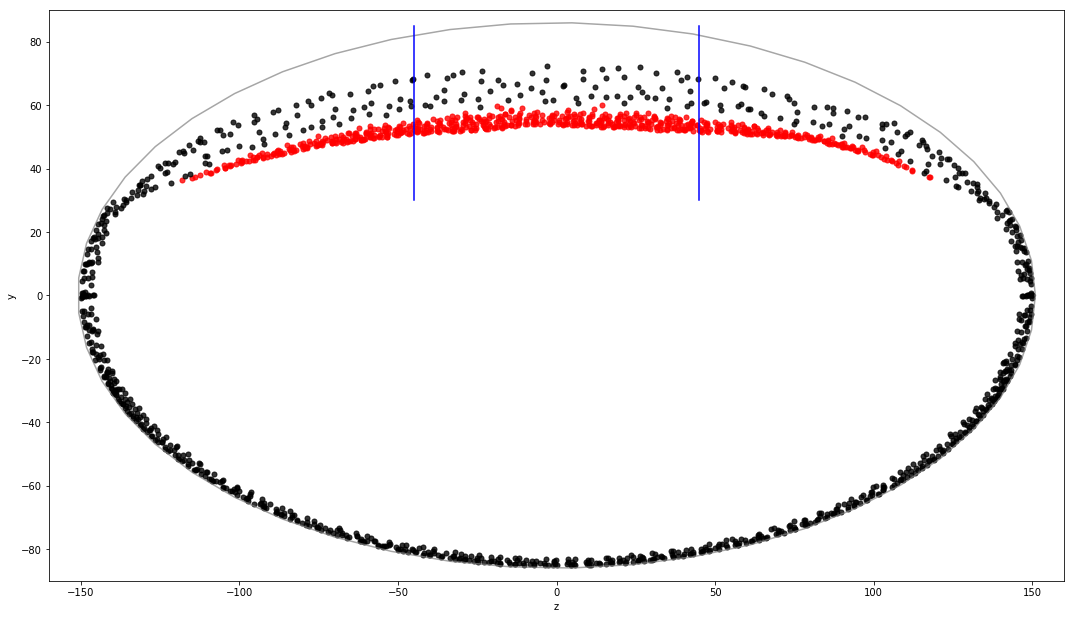

In [4]:
import matplotlib.gridspec as gridspec
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/test/')
#SIM_DIR = Path('/media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/2018-09-07_TEST1/')
dirname = SIM_DIR/'1.08_contractility_5_critical_area_30_radialtension_0/'
sheet = open_sheet(dirname, 50, ['vert', 'edge', 'face'])
sheet_mesoderm = sheet.extract('is_mesoderm')

sheet_mesoderm = sheet.face_df[(sheet.face_df['contractility']!=0) & 
                              (sheet.face_df['is_mesoderm'])]
sheet_ectoderm = sheet.face_df[(~sheet.face_df['is_mesoderm']) & (sheet.face_df.x>-20)&(sheet.face_df.x<20)]

edge_specs = {'alpha': 0.6,
              'lw': 0.1,
              'color': 'white'}
scatter_specs = {'alpha': 0.8,
                 'ms': 5,
                 'color': 'red'}


#plt.figure(figsize=(18.5, 10.5))
fig, ax = plt.subplots(figsize=(18.5, 10.5))



#Retire visuellement les cellules qui ont été ablaté apicalement
datasets={}
datasets['face'] = sheet.face_df[sheet.face_df['contractility']!=0].copy()

datasets['edge'] = sheet.edge_df[sheet.edge_df['face'].isin(
                    datasets['face'].index)].copy()
datasets['vert'] = sheet.vert_df.loc[sheet.edge_df['srce'].unique()].copy()

sheet = Sheet('subsheet', datasets, sheet.specs)
sheet.reset_index()
sheet.reset_topo()



u, v = ('z', 'y')
fig, ax = quick_edge_draw(sheet.extract_bounding_box(x_boundary=(-5,5)),
                          coords=('z', 'y'),
                          ax = ax,
                          **edge_specs)

ax.plot(sheet_mesoderm[u],
        sheet_mesoderm[v],
        'o', **scatter_specs)
scatter_specs = {'alpha': 0.8,
                 'ms': 5,
                 'color': 'k'}
ax.plot(sheet_ectoderm[u],
        sheet_ectoderm[v],
        'o', **scatter_specs)
"""
sheet_dead = sheet.face_df[sheet.face_df['contractility']!=0]
scatter_specs2 = {'alpha': 1,
                 'ms': 5.5,
                 'color': 'white'}
ax.plot(sheet_dead[u],
        sheet_dead[v],
        'o', **scatter_specs2)
        """


"""sheet = sheet.extract_bounding_box(x_boundary=(-10,10))
res=(sheet.edge_df[(sheet.edge_df.srce.isin(sheet.vert_df[sheet.vert_df.radial_tension==0].index))
                           &
                           (sheet.edge_df.trgt.isin(sheet.vert_df[sheet.vert_df.radial_tension==0].index))])
for f in res.face.unique() : 
    if len(res[res.face==f]) == 1:
        res= res.drop(res[res.face==f].index)
sheet_no_force = sheet.face_df[(sheet.face_df.index.isin(res.face.unique())) & sheet.face_df.is_mesoderm == True]
scatter_specs2 = {'alpha': 1,
                 'ms': 5.5,
                 'color': 'orange'}
ax.plot(sheet_no_force[u],
        sheet_no_force[v],
        'o', **scatter_specs2)"""

ax.set_ylim(-90,90)
ax.set_xlim(-160,160)

ax.set_xlabel(u)
ax.set_ylabel(v)

a = 86
c = 151
thetas = np.linspace(0, 2 * np.pi)
ax.plot(c * np.cos(thetas), a * np.sin(thetas), color='grey', alpha=0.7)

#ax.plot((-45,45), (30,30), color="blue")
ax.plot((-45,-45), (30,85), color= "blue")
ax.plot((45,45), (30,85), color='blue')

#plt.savefig('../TEST5_simul_15_coupe_50.png', dpi = 300)

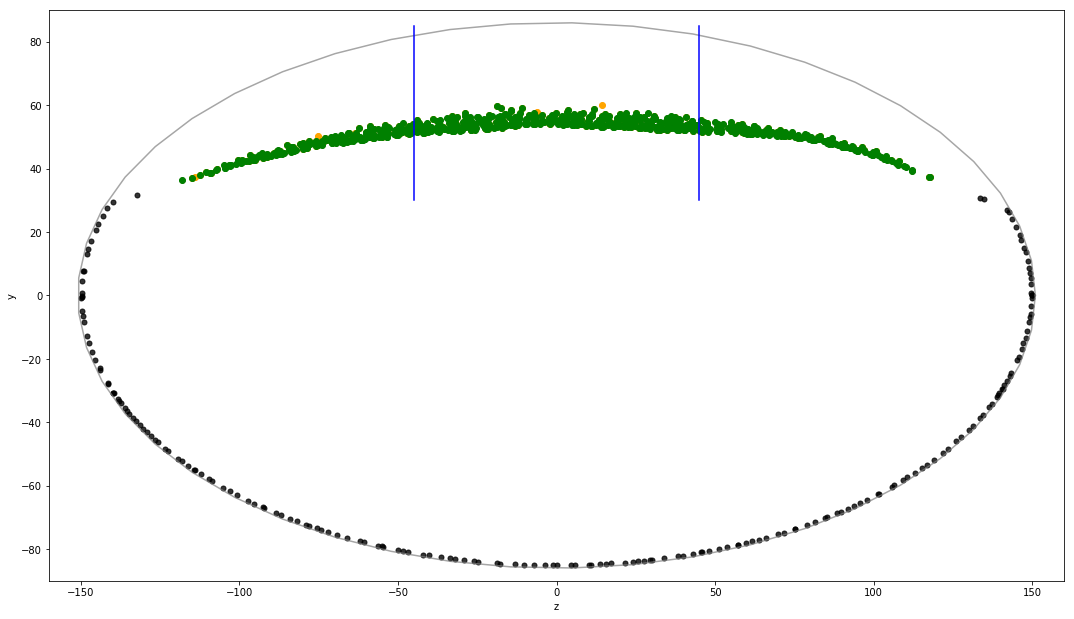

In [5]:
import matplotlib.gridspec as gridspec
#SIM_DIR = Path('/media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/Simulations/Ablations/2018-09-08_TEST3/')
#dirname = SIM_DIR/'1.08_contractility_5_critical_area_30_radialtension_0/'
#sheet = open_sheet(dirname, 50)

sheet_mesoderm = sheet.face_df[(sheet.face_df['is_mesoderm']) & (sheet.face_df.x>-5)&(sheet.face_df.x<5)]
sheet_ectoderm = sheet.face_df[(~sheet.face_df['is_mesoderm']) & (sheet.face_df.x>-5)&(sheet.face_df.x<5)
                              & (sheet.face_df.y>-100)&(sheet.face_df.y<32)]

edge_specs = {'alpha': 0.6,
              'lw': 0.1,
              'color': 'white'}
scatter_specs = {'alpha': 0.8,
                 'ms': 5,
                 'color': 'red'}


#plt.figure(figsize=(18.5, 10.5))
fig, ax = plt.subplots(figsize=(18.5, 10.5))



#Retire visuellement les cellules qui ont été ablaté apicalement
datasets={}
datasets['face'] = sheet.face_df[sheet.face_df['contractility']!=0].copy()

datasets['edge'] = sheet.edge_df[sheet.edge_df['face'].isin(
                    datasets['face'].index)].copy()
datasets['vert'] = sheet.vert_df.loc[sheet.edge_df['srce'].unique()].copy()

sheet = Sheet('subsheet', datasets, sheet.specs)
sheet.reset_index()
sheet.reset_topo()



u, v = ('z', 'y')
fig, ax = quick_edge_draw(sheet.extract_bounding_box(x_boundary=(-10,10)),
                          coords=('z', 'y'),
                          ax = ax,
                          **edge_specs)

ax.plot(sheet_mesoderm[u],
        sheet_mesoderm[v],
        'o', **scatter_specs)
scatter_specs = {'alpha': 0.8,
                 'ms': 5,
                 'color': 'k'}
ax.plot(sheet_ectoderm[u],
        sheet_ectoderm[v],
        'o', **scatter_specs)

ax.set_ylim(-90,90)
ax.set_xlim(-160,160)

ax.set_xlabel(u)
ax.set_ylabel(v)

a = 86
c = 151
thetas = np.linspace(0, 2 * np.pi)
ax.plot(c * np.cos(thetas), a * np.sin(thetas), color='grey', alpha=0.7)


pulling_vert = sheet.vert_df[sheet.vert_df.radial_tension==0].index
pulling_face = sheet.edge_df[sheet.edge_df.srce.isin(pulling_vert)].face.unique()
ax.plot(sheet.face_df[sheet.face_df.index.isin(pulling_face) & sheet.face_df.is_mesoderm].z,
        sheet.face_df[sheet.face_df.index.isin(pulling_face) & sheet.face_df.is_mesoderm].y,
       'o', color='orange')

pulling_vert = sheet.vert_df[sheet.vert_df.radial_tension>0].index
pulling_face = sheet.edge_df[sheet.edge_df.srce.isin(pulling_vert)].face.unique()
ax.plot(sheet.face_df[sheet.face_df.index.isin(pulling_face) & sheet.face_df.is_mesoderm].z,
        sheet.face_df[sheet.face_df.index.isin(pulling_face) & sheet.face_df.is_mesoderm].y,
       'o', color='green')



#ax.plot(sheet.vert_df.z, sheet.vert_df['is_active']*20, 'ko')
ax.plot((-45,-45), (30,85), color= "blue")

ax.plot((45,45), (30,85), color='blue')
#plt.savefig('../TEST5_simul_0_coupe_50.png', dpi = 300)

In [237]:
sheet.face_df[sheet.face_df.is_mesoderm]

,z,x,num_sides,area,perimeter,is_alive,y,face_o,height,rho,contractility,prefered_area,area_elasticity,prefered_height,prefered_vol,is_mesoderm,is_relaxation,id,enter_in_process
face,,,,,,,,,,,,,,,,,,,
45,118.023428,-0.515086,6,2.309618,6.957430,True,22.531024,45,25.168292,22.537941,5.966199,28.0,1.0,32,896,True,False,45,0
46,120.130873,-0.046530,6,2.633432,6.906638,True,22.136293,46,26.330368,22.138421,6.584441,28.0,1.0,32,896,True,False,46,0
47,121.134525,-0.581238,7,2.624140,7.152820,True,23.053563,47,28.028727,23.062065,7.967453,28.0,1.0,32,896,True,False,47,0
48,117.186352,-0.057828,6,3.189334,7.459415,True,21.649067,48,23.679654,21.651207,5.686467,28.0,1.0,32,896,True,False,48,0
49,120.948002,1.208444,6,2.220395,7.117179,True,21.431820,49,26.291570,21.469407,6.842586,28.0,1.0,32,896,True,False,49,0
50,117.651787,1.214358,7,2.199507,7.047769,True,20.857316,50,23.258139,20.895406,7.035795,28.0,1.0,32,896,True,False,50,0
51,119.851164,1.734636,6,1.570629,6.177001,True,21.346165,51,25.397283,21.418086,6.468373,28.0,1.0,32,896,True,False,51,0
52,114.701238,1.525472,7,2.031953,6.697553,True,20.503260,52,20.868794,20.561145,6.326607,28.0,1.0,32,896,True,False,52,0
53,114.945184,0.965738,5,1.584014,6.010239,True,20.393871,53,20.889331,20.419883,4.479469,28.0,1.0,32,896,True,False,53,0


In [241]:
pulling_vert = sheet.vert_df[sheet.vert_df.radial_tension>0].index
pulling_face = sheet.edge_df[sheet.edge_df.srce.isin(pulling_vert)].face.unique()
sheet.face_df[sheet.face_df.index.isin(pulling_face) & sheet.face_df.is_mesoderm].z

,z,x,num_sides,area,perimeter,is_alive,y,face_o,height,rho,contractility,prefered_area,area_elasticity,prefered_height,prefered_vol,is_mesoderm,is_relaxation,id,enter_in_process
face,,,,,,,,,,,,,,,,,,,
45,118.023428,-0.515086,6,2.309618,6.957430,True,22.531024,45,25.168292,22.537941,5.966199,28.0,1.0,32,896,True,False,45,0
46,120.130873,-0.046530,6,2.633432,6.906638,True,22.136293,46,26.330368,22.138421,6.584441,28.0,1.0,32,896,True,False,46,0
47,121.134525,-0.581238,7,2.624140,7.152820,True,23.053563,47,28.028727,23.062065,7.967453,28.0,1.0,32,896,True,False,47,0
48,117.186352,-0.057828,6,3.189334,7.459415,True,21.649067,48,23.679654,21.651207,5.686467,28.0,1.0,32,896,True,False,48,0
49,120.948002,1.208444,6,2.220395,7.117179,True,21.431820,49,26.291570,21.469407,6.842586,28.0,1.0,32,896,True,False,49,0
50,117.651787,1.214358,7,2.199507,7.047769,True,20.857316,50,23.258139,20.895406,7.035795,28.0,1.0,32,896,True,False,50,0
51,119.851164,1.734636,6,1.570629,6.177001,True,21.346165,51,25.397283,21.418086,6.468373,28.0,1.0,32,896,True,False,51,0
52,114.701238,1.525472,7,2.031953,6.697553,True,20.503260,52,20.868794,20.561145,6.326607,28.0,1.0,32,896,True,False,52,0
53,114.945184,0.965738,5,1.584014,6.010239,True,20.393871,53,20.889331,20.419883,4.479469,28.0,1.0,32,896,True,False,53,0
